# Imports

In [22]:
#!pip install -U scikit-learn

In [23]:
from Transformation import Transformation
import numpy as np
import math
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors
import networkx as nx

# Input

In [24]:
transformation = Transformation()

# Create objects
stl_file_path = "3d_models/stl/Handle.stl"
mesh_data = transformation.stl_to_mesh(stl_file_path)
graph = transformation.mesh_to_graph(mesh_data)

transformation.print_graph_properties(graph, display_graph=False, display_labels=False)

Number of nodes: 5999
Number of edges: 17991


In [25]:
print(graph._node)

{(75.0252, -0.66553295, 3.8): {'index_triangle': {0, 6820, 164, 165, 6821, 6822}}, (75.01418, -0.49935842, 16.7): {'index_triangle': {0, 1, 165, 370, 371, 372}}, (75.0, 0.0, 3.8): {'index_triangle': {0, 1, 2, 6658, 6659, 11415, 11416, 11417, 6822, 6823, 6824, 6825, 6826, 6827, 6828, 6829, 6830, 6831, 6832, 6833, 6834, 6835, 6836, 6837, 6838, 6839, 6840, 6841, 6842, 6843, 6844, 6845, 6846, 6847, 6848, 6849, 6850, 6851, 6852, 6853, 6854, 6855, 6856, 6857, 6858, 6859, 6860, 6861, 6862, 6863, 6864, 6865, 6866, 6867, 6868, 6869, 6870, 6871, 6872, 6873, 6874, 6875, 6876, 6877, 6878, 6495}}, (75.00158, 0.16653232, 16.7): {'index_triangle': {1, 2, 3, 372, 373, 374}}, (75.0252, 0.66553295, 3.8): {'index_triangle': {2, 6659, 3, 4, 6660}}, (75.03937, 0.8314692, 16.7): {'index_triangle': {3, 4, 5, 374, 375, 376}}, (75.10067, 1.3272538, 3.8): {'index_triangle': {6660, 6661, 4, 5, 6, 6662}}, (75.12734, 1.4916434, 16.7): {'index_triangle': {5, 6, 7, 376, 377, 378}}, (75.22596, 1.9813722, 3.8): {'inde

# Point Sampler

### DevConv

In [26]:
def relu(array):
    return np.maximum(array, 0)

def sigmoid(array):
    return 1 / (1 + np.exp(-array))

In [27]:
class DevConv():
    def __init__(self, graph, output_dimension):
        self.graph = graph
        self.list_node = list(graph._node)

        self.W_phi = np.random.random((output_dimension))      #change
        self.W_theta = np.array([1, 2, 3])  # change
    
    def forward(self, previous_inclusion_score, return_flatten=True):
        list_inc_score = np.zeros((len(self.list_node), len(self.W_phi)))
        for index_current_node, (current_node, dict_neigh) in enumerate(self.graph._adj.items()):
            # print(index_current_node, " | ", current_node, " | ", dict_neigh)
            neigh_distances = np.zeros(shape=len(dict_neigh))
            for index_neigh, neigh_node in enumerate(dict_neigh.keys()):
                neigh_distances[index_neigh] = np.linalg.norm(np.multiply(self.W_theta, np.array(current_node) - np.array(neigh_node))) # norm(W_theta * (xi - xj))
            list_inc_score[index_current_node] = self.W_phi * np.max(neigh_distances)                                   # W_phi * max(distance)    

        # return if no previous inclusion score
        if len(previous_inclusion_score)==0:
            if return_flatten:
                list_inc_score = list_inc_score.flatten()
            return list_inc_score
        
        # mean the rows if more than one column
        if list_inc_score.shape[1]!=1:
            list_inc_score = np.mean(list_inc_score, axis=1)

        # array of array to array
        if len(list_inc_score.shape)==2:
            if list_inc_score.shape[1]==1:
                list_inc_score = list_inc_score.flatten()

        # Return the mean of previous and current inclusion score
        return np.mean(np.array([previous_inclusion_score, list_inc_score], dtype=np.float64), axis=0)
        

In [28]:
devconv = DevConv(graph, 1)
inclusion_score = devconv.forward(previous_inclusion_score=np.array([]))
inclusion_score = relu(inclusion_score)
print(inclusion_score)

devconv = DevConv(graph, 64)
inclusion_score = devconv.forward(previous_inclusion_score=inclusion_score)
inclusion_score = relu(inclusion_score)
print(inclusion_score)

devconv = DevConv(graph, 1)
inclusion_score = devconv.forward(previous_inclusion_score=inclusion_score)
inclusion_score = sigmoid(inclusion_score)
print(inclusion_score)
print(inclusion_score.shape)

[28.97175469 28.97921586 28.97182698 ...  9.10173953 26.1178852
  9.10327824]
[24.96929281 24.97572322 24.96935511 ...  7.84432983 22.50968677
  7.84565597]
[0.99999999 0.99999999 0.99999999 ... 0.99737774 0.99999996 0.99738036]
(5999,)


### Multinomial Sampling

In [29]:
normalized_inclusion_score = inclusion_score / np.sum(inclusion_score)  # normalize for multinomial sampling
normalized_inclusion_score = np.round(normalized_inclusion_score, 8)    # round to remove float imprecision

number_throws = 500     # small:more randomness    |   big:less randomness
mult_sampling = np.random.multinomial(number_throws, normalized_inclusion_score)
print(mult_sampling)

[0 1 0 ... 0 0 0]


In [30]:
target_number_point = min(len(graph._node), 50)   # number of points for the simplification

index_k_nodes = np.argpartition(mult_sampling, -target_number_point)[-target_number_point:]
list_k_nodes = np.array(list(graph._node.keys()))[index_k_nodes]
list_k_nodes = [tuple(e) for e in list_k_nodes]
print(list_k_nodes)

[(75.434425, -8.78582, -4.489266), (75.62203, -6.0434117, 1.4785457), (63.0, -1.8187612, -13.610001), (75.0, -0.99710757, 98.743324), (75.26499, 2.1432736, 55.4), (78.63775, -7.6759295, 83.84298), (78.77108, -7.6759295, 83.64897), (75.331566, -8.447791, -2.5266018), (76.83904, -0.33300498, -13.697317), (78.500145, -7.328478, 2.0165868), (63.0, -5.921278, 83.49013), (75.020386, -0.66553295, 81.21481), (78.588684, -7.328478, 2.2022145), (75.19, -1.8187612, 55.4), (75.82059, -3.710653, 55.4), (76.47152, -4.871695, 55.4), (75.23533, -7.6759295, -0.69033855), (75.0, -6.9390492, 0.41198632), (92.5937, -0.33300498, 81.2), (80.86944, -8.78582, -2.06944), (75.63882, -8.114116, 93.38931), (75.0, -6.0434117, 1.3966535), (76.31722, -7.9794145, 86.11593), (80.50911, 8.237194, 2.3238392), (75.0, -3.8609922, 2.9077644), (75.07711, -1.1623888, 29.6), (88.247986, -7.593115, 42.5), (78.31398, -6.9390492, 3.0955923), (75.00132, -0.66553295, 3.7748318), (84.512886, 8.760632, 82.706696), (92.32734, 0.99710

# KNN

In [31]:
XYZ = [list(e) for e in list_k_nodes]
print(XYZ)

[[75.434425, -8.78582, -4.489266], [75.62203, -6.0434117, 1.4785457], [63.0, -1.8187612, -13.610001], [75.0, -0.99710757, 98.743324], [75.26499, 2.1432736, 55.4], [78.63775, -7.6759295, 83.84298], [78.77108, -7.6759295, 83.64897], [75.331566, -8.447791, -2.5266018], [76.83904, -0.33300498, -13.697317], [78.500145, -7.328478, 2.0165868], [63.0, -5.921278, 83.49013], [75.020386, -0.66553295, 81.21481], [78.588684, -7.328478, 2.2022145], [75.19, -1.8187612, 55.4], [75.82059, -3.710653, 55.4], [76.47152, -4.871695, 55.4], [75.23533, -7.6759295, -0.69033855], [75.0, -6.9390492, 0.41198632], [92.5937, -0.33300498, 81.2], [80.86944, -8.78582, -2.06944], [75.63882, -8.114116, 93.38931], [75.0, -6.0434117, 1.3966535], [76.31722, -7.9794145, 86.11593], [80.50911, 8.237194, 2.3238392], [75.0, -3.8609922, 2.9077644], [75.07711, -1.1623888, 29.6], [88.247986, -7.593115, 42.5], [78.31398, -6.9390492, 3.0955923], [75.00132, -0.66553295, 3.7748318], [84.512886, 8.760632, 82.706696], [92.32734, 0.99710

In [32]:
def connect_extended_graph(XYZ, number_neigh=3):
    is_graph_connected = False
    while not is_graph_connected:
        # Create the nearest neighbors object
        _, indices = NearestNeighbors(n_neighbors=number_neigh).fit(XYZ).kneighbors(XYZ)
        # Create the graph from the nearest points
        extended_graph = nx.Graph()
        for index_poly, poly in enumerate(indices):
            for index_current_node in range(len(poly)):
                current_node = list_k_nodes[poly[index_current_node]]
                for index_other_node in range(index_current_node+1, len(poly)):
                    edge = current_node, list_k_nodes[poly[index_other_node]]
                    extended_graph.add_edge(*edge)
                    # if attribute do not exists
                    if len(extended_graph.nodes[current_node])==0:
                        extended_graph.nodes[current_node]['index_poly'] = set()
                    extended_graph.nodes[current_node]['index_poly'].add(index_poly)
        is_graph_connected = nx.is_connected(extended_graph)
        number_neigh += 1
    print("Number of neighbors : ", number_neigh-1)
    return extended_graph

In [33]:
extended_graph = connect_extended_graph(XYZ)

Number of neighbors :  8


Number of nodes: 50
Number of edges: 352


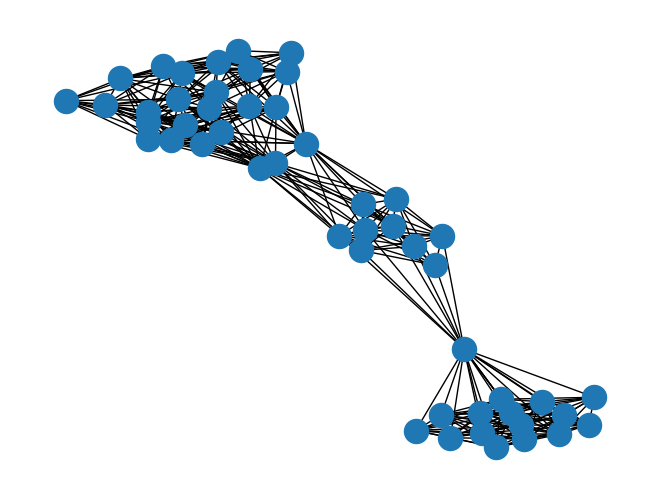

In [34]:
transformation.print_graph_properties(graph=extended_graph, display_graph=True, display_labels=False)

# Edge Predictor

In [35]:
devconv = DevConv(extended_graph, 64)
inclusion_score = devconv.forward(previous_inclusion_score=np.array([]), return_flatten=False)
print(inclusion_score.shape)

(50, 64)


In [36]:
"""
inclusion_score = [[f_1_1  , f_1_2  , ..., f_63_1  ],
                    ...,
                   [f_1_M-1, f_1_M-1, ..., f_63_M-1]]
M = number of points
64 = hidden dimensions
"""
from numpy import mean


f1i = np.mean(inclusion_score)
f1j = np.mean(inclusion_score)
wq = np.random.randint(100, size=(64,1))
wk = np.random.randint(100, size=(1,64))

f1i_wq = f1i*wq
f1j_wk = f1j*wk

wq_wk = int(np.matmul(f1j_wk, f1i_wq)) 

expo = np.exp(wq_wk)



C:\Users\Arthur\AppData\Local\Temp\ipykernel_6596\73126498.py:21: RuntimeWarning: overflow encountered in exp
  expo = np.exp(wq_wk)


### Sparse Attention

# Face Candidates

#### Inputs

In [84]:
adjacency = nx.adjacency_matrix(extended_graph)
S = np.random.rand(target_number_point, target_number_point)
print(adjacency)
print(S)



  (0, 1)	1
  (0, 2)	1
  (0, 3)	1
  (0, 4)	1
  (0, 5)	1
  (0, 6)	1
  (0, 7)	1
  (0, 11)	1
  (0, 12)	1
  (0, 33)	1
  (0, 34)	1
  (0, 35)	1
  (0, 36)	1
  (0, 41)	1
  (1, 0)	1
  (1, 2)	1
  (1, 3)	1
  (1, 4)	1
  (1, 5)	1
  (1, 6)	1
  (1, 7)	1
  (1, 8)	1
  (1, 9)	1
  (1, 10)	1
  (1, 11)	1
  :	:
  (47, 48)	1
  (48, 4)	1
  (48, 8)	1
  (48, 12)	1
  (48, 33)	1
  (48, 34)	1
  (48, 36)	1
  (48, 41)	1
  (48, 42)	1
  (48, 43)	1
  (48, 44)	1
  (48, 45)	1
  (48, 46)	1
  (48, 47)	1
  (49, 9)	1
  (49, 10)	1
  (49, 21)	1
  (49, 22)	1
  (49, 23)	1
  (49, 24)	1
  (49, 25)	1
  (49, 26)	1
  (49, 27)	1
  (49, 39)	1
  (49, 45)	1
[[0.42458998 0.31043276 0.55198025 ... 0.64366773 0.96170431 0.48499811]
 [0.16008869 0.94853493 0.36265789 ... 0.10030569 0.92348058 0.64442613]
 [0.45098005 0.94907736 0.29113306 ... 0.52356946 0.71661948 0.99267651]
 ...
 [0.11714715 0.4653621  0.21344758 ... 0.64532955 0.40408921 0.91721991]
 [0.68582165 0.83956459 0.06304898 ... 0.16258318 0.68152453 0.92060319]
 [0.62345942 0.374

In [129]:
A_s = np.zeros((target_number_point,target_number_point))

for i in range(target_number_point):
    for j in range(target_number_point):
        A_s[i,j] = np.matmul(np.matmul(S[i,:], adjacency.A), S[j,:][np.newaxis].T)

print(A_s)  # symmétrique
print(A_s.shape)

[[193.75404203 203.95401258 181.01712836 ... 200.750938   171.49594524
  180.92808532]
 [203.95401258 205.70900111 185.28686557 ... 208.94361409 178.29897645
  187.38835161]
 [181.01712836 185.28686557 162.68810119 ... 185.87327323 159.1380231
  167.1530688 ]
 ...
 [200.750938   208.94361409 185.87327323 ... 206.38098405 179.55132956
  185.70587011]
 [171.49594524 178.29897645 159.1380231  ... 179.55132956 150.39843851
  158.9001912 ]
 [180.92808532 187.38835161 167.1530688  ... 185.70587011 158.9001912
  165.94587408]]
(50, 50)


c:\Users\Arthur\miniconda3\envs\meshPFE\lib\site-packages\scipy\sparse\_base.py:719: VisibleDeprecationWarning: `.A` is deprecated and will be removed in v1.13.0. Use `.toarray()` instead.
  warn(np.VisibleDeprecationWarning(


# Face Classifier

### TriConv

# Simplified Mesh